In [2]:
import random
import numpy as np
import networkx as nx
import seaborn as sns
import pickle
%matplotlib inline

# Loading a graph

In [8]:
dirTemp = "temp/" #directory for manipulating graphs and embedding
G = pickle.load( open( dirTemp+"pickledGraph.p", "rb" ) )

# Generating random walks on a graph
#adapted (simplified) from

https://github.com/eliorc/node2vec/tree/master/node2vec

In [55]:
def generate_walks(d_graph, walk_length, num_walks,probabilities_key=None):
    """
    Generates the random walks which will be used as the skip-gram input.
    :return: List of walks. Each walk is a list of nodes.
    """

    walks = list()


    # ------------for the number of walks we want to run-------------
    for n_walk in range(num_walks):


        # Shuffle the nodes
        shuffled_nodes = list(d_graph.nodes())
        random.shuffle(shuffled_nodes)

        # ------------Start a random walk from every node------------
        for source in shuffled_nodes:

            # Start walk
            walk = [source]

            # ------------Perform walk------------
            while len(walk) < walk_length:
                # ------------Get the neighbors------------
                #walk_options = G.neighbors(walk[-1])
                walk_options = G[walk[-1]]
                nodes = [n for n in walk_options]
                probas = [v["weight"] for v in walk_options.values()]
                prob_factor = 1 / sum(probas)
                probas = [prob_factor * p for p in probas]



                # Skip dead end nodes
                if len(walk_options)==0:
                    break
                
                # ------------Choose randomly a neighbor------------
                # For the first step
                walk_to = np.random.choice(nodes, size=1,p=probas)[0]
                walk.append(walk_to)

           # walk = list(map(str, walk))  # Convert all to strings

            walks.append(walk)

    return walks

In [57]:
walks = generate_walks(G,walk_length=80,num_walks=10)

# Run Word2Vec on the random walks
Of course, the right solution is to use one of the many efficient implementations.
for instance, one can use : 

```css
embedding = gensim.models.Word2Vec(self.walks, **skip_gram_params)
```

But here, we will look at a basic, simple matrix implementation

It is taken (simplified) from: 

https://github.com/cbellei/word2veclite/blob/master/word2veclite/word2veclite.py

In [58]:
# The main method that does the parameter learning
def cbow(context, label, W1, W2, loss):
        """
        Implementation of Continuous-Bag-of-Words Word2Vec model
        :param context: all the context words (these represent the inputs)
        :param label: the center word (this represents the label)
        :param W1: weights from the input to the hidden layer
        :param W2: weights from the hidden to the output layer
        :param loss: float that represents the current value of the loss function
        :return: updated weights and loss
        """
        # context is 'x' from tokenizer, it is a c x V matrix
        # label is 'y' from tokenizer, it is a 1 x V matrix
        x = np.matrix(np.mean(context, axis=0))
        
        # x is a 1 x V matrix
        # W1 is a VxN matrix
        # h is a N x 1 matrix
        h = np.matmul(W1.T, x.T)
        
        # u is a V x 1 matrix
        u = np.matmul(W2.T, h)
        
        # W2 is an N x V matrix
        # y_pred is a V x 1 matrix
        y_pred = softmax(u)
        # e is a V x 1 matrix
        e = -label.T + y_pred
        # h is N x 1 and e is V x 1 so dW2 is N x V
        dW2 = np.outer(h, e)
        # x.T is a V x 1 matrix, W2e is a Nx1 so dW1 this is V x N
        dW1 = np.outer(x.T, np.matmul(W2, e))

        new_W1 = W1 - eta * dW1
        new_W2 = W2 - eta * dW2

        # label is a 1xV matrix so label.T is a Vx1 matrix
        loss += -float(u[label.T == 1]) + np.log(np.sum(np.exp(u)))

        return new_W1, new_W2, loss

In [59]:
#A utility function to compute the "softmax"
def softmax(x):
    """Calculate softmax based probability for given input vector
    # Arguments
        x: numpy array/list
    # Returns
        softmax of input array
    """
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)
#A utility function to compute "contexts" and "central words" from "sentances"
def corpus2io(corpus_tokenized, nbNodes, window_size):
    """Converts corpus text into context and center words
    # Arguments
        corpus_tokenized: corpus text
        window_size: size of context window
    # Returns
        context and center words (arrays)
    """
    #for each "sentance" in the corpus
    for words in corpus_tokenized:
        #how many words in the sentance
        L = len(words)
        #
        for index, word in enumerate(words):
            contexts = []
            center = -1
            #s : index of first element of the context
            s = index - window_size
            #e : index of last element of the context
            e = index + window_size + 1
            #extract words in the context
            contexts = contexts + [words[i] for i in range(s, e) if 0 <= i < L and i != index]
            center = word ##If I understand correctly, -1 earlier was because we considered that words start at 1
            # x has shape c x V where c is size of contexts
            ###x = np_utils.to_categorical(contexts, V)
            x = np.zeros((len(contexts),nbNodes))
            for i in range(len(contexts)):
                x[i][contexts[i]]=1
            
            # y has shape k x V where k is number of center words
            y=np.zeros((1,nbNodes))#[0]*nbNodes
            y[0][center]=1
            ###y = np_utils.to_categorical(center, V)
            yield (x, y)

In [60]:
 def initialize(V, N):
    """
    Initialize the weights of the neural network.
    :param V: size of the vocabulary
    :param N: size of the hidden layer
    :return: weights W1, W2
    """
    np.random.seed(100)
    W1 = np.random.rand(V, N)
    W2 = np.random.rand(N, V)

    return W1, W2

# The main code 

Takes some "corpus" of "sentences" (for us, random walks) and launch the learning.  

In [76]:
nbNodes = G.number_of_nodes()
#print(G.nodes())
eta = 0.1 #learning_rate
n_epochs = 8
windowSize=3
W1,W2 = initialize(nbNodes,8) #nb nodes and dimensions of the embedding
loss_vs_epoch = []
for e in range(n_epochs):
    loss = 0.
    print(W1[0])
    print("epoch",e)
    for (context, center) in corpus2io(walks,nbNodes,windowSize):
        (W1, W2, loss) = cbow(context,center,W1,W2,loss)
    loss_vs_epoch.append(loss)

[0.54340494 0.27836939 0.42451759 0.84477613 0.00471886 0.12156912
 0.67074908 0.82585276]
epoch 0
[-0.533682    1.51642224  0.30552769  0.18061305 -0.78161563  0.36671663
  1.32692724  0.71641939]
epoch 1
[-0.41975098  1.50547114  0.21153467  0.17857522 -0.94645317  0.35276486
  1.34883146  0.93759689]
epoch 2
[-0.39927272  1.43163357  0.12917653  0.18291595 -1.00904323  0.37721266
  1.4322095   1.04730813]
epoch 3
[-0.38708792  1.36774984  0.06414811  0.16815522 -0.99704716  0.39745885
  1.50706254  1.09355997]
epoch 4
[-0.37068958  1.30661471  0.01326211  0.14340978 -0.96490089  0.41602215
  1.57079552  1.1145901 ]
epoch 5
[-0.35169223  1.25138755 -0.02619262  0.11402066 -0.92956761  0.43596059
  1.62656742  1.11990297]
epoch 6
[-0.33092945  1.20443741 -0.05825591  0.08403561 -0.89614078  0.45938283
  1.67566445  1.11528426]
epoch 7


/Users/cazabetremy/anaconda3/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


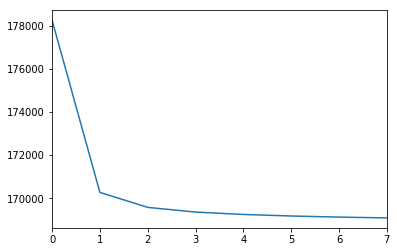

In [77]:
#plotting the learning procedure
sns.tsplot(loss_vs_epoch)

# Saving the embedding

In [78]:
dirTemp = "temp/" #directory for manipulating graphs and embedding
shape = str(W1.shape[0])+" "+str(W1.shape[1])
toPrint = np.c_[ np.arange(0,nbNodes), W1 ]
np.savetxt(dirTemp+"custom.emb",  toPrint, delimiter=" ",header=shape,comments="")